In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"

USERS_FILTERED = DATA_DIR_PROC / "yelp_filtered_user_ids.csv"

special_ids = set(pd.read_csv(USERS_FILTERED)["user_id"].astype(str))


In [2]:
user = pd.read_json(USERS, lines=True, dtype={"user_id": str}, engine="pyarrow")
user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [3]:
review = pd.read_json(REVIEWS_CLEAN, lines=True, engine="pyarrow")
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
#usecols = ["business_id","categories","is_open", "stars", "review_count"]
usecols = ["business_id","name","categories","city","state","is_open", "stars", "review_count"]
df = pd.read_json(BIZ, lines=True, dtype_backend="pyarrow")[usecols]    
print(len(df))

150346


In [5]:
# drop nans 
df = df.dropna(subset=["categories"])
print(len(df))

150243


In [6]:
#drop closed restaurants 
df = df[(df["is_open"] == 1)]
print(len(df))

119603


In [7]:
# drop column is open 
df = df.drop(columns=["is_open"])

In [8]:
# unique categories 
len(df["categories"].unique())

68085

In [9]:
# Keep only the once that contain restaurants/food
is_foodish = df["categories"].str.contains(r"\b(?:Restaurants|Food)\b", case=False, na=False)
df = df[is_foodish]

In [10]:
# Load all the categories from the text files 
def get_categories(restaurants_file=RESTAURANTS, food_file=FOOD):
    cats = []
    with open(restaurants_file) as f:
        for line in f:
            s = line.strip()
            if s and s != "Restaurants":
                cats.append(s)
    with open(food_file) as f:
        for line in f:
            s = line.strip()
            if s and s != "Food":
                cats.append(s)
    return cats

In [16]:
CATEGORIES_IN_ORDER = get_categories()

print("n cats:", len(CATEGORIES_IN_ORDER))
print(CATEGORIES_IN_ORDER[:12])

# set a seed 
random.seed(1337)

# 6) Random version: picks ANY matching category randomly
def simplify_random(categories_string):
    """
    Random version: instead of picking the first match,
    find ALL matches and pick one randomly
    """
    business_cats = {c.strip() for c in categories_string.split(",")}
    
    # Build a list of ALL categories that match
    matching_categories = []
    for cat in CATEGORIES_IN_ORDER:
        if cat in business_cats:
            matching_categories.append(cat)
    
    # If we found any matches, pick one at random
    if matching_categories:
        return random.choice(matching_categories)
    return "Other"

df["simple_category"] = df["categories"].apply(simplify_random)



n cats: 218
['Afghan', 'African', 'Senegalese', 'South African', 'American (New)', 'American (Traditional)', 'Arabian', 'Argentine', 'Armenian', 'Asian Fusion', 'Australian', 'Austrian']


In [17]:
df["categories"].head(10)

3     Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                             Brewpubs, Breweries, Food
5     Burgers, Fast Food, Sandwiches, Food, Ice Crea...
9     Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
11           Vietnamese, Food, Restaurants, Food Trucks
12    American (Traditional), Restaurants, Diners, B...
15                    Sushi Bars, Restaurants, Japanese
19                                  Korean, Restaurants
22               Steakhouses, Asian Fusion, Restaurants
23                                 Restaurants, Italian
Name: categories, dtype: string[pyarrow]

In [18]:
len(df["simple_category"].unique())

200

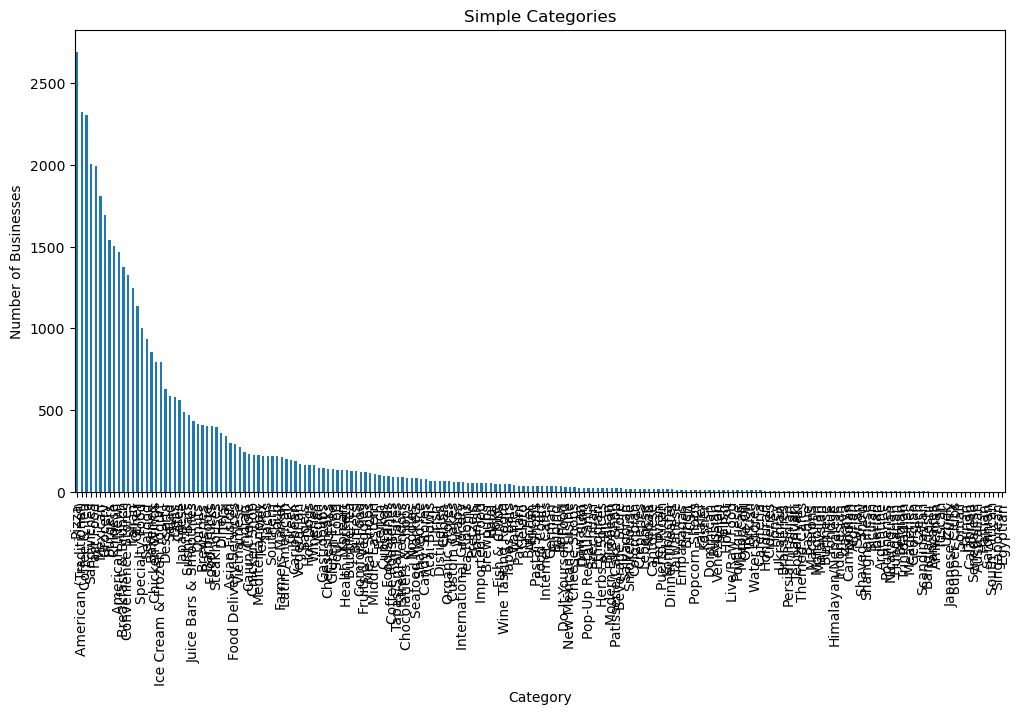

In [20]:
category_counts = df["simple_category"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,6))
category_counts.head(len(df)).plot(kind='bar')
plt.title("Simple Categories")
plt.xlabel("Category")
plt.ylabel("Number of Businesses")
plt.show()

In [26]:
vc = df["simple_category"].value_counts()
print("Share of the first top 10 companies:", vc.head(10).sum()/vc.sum())


Share of the first top 10 companies: 0.43385222735633217


#### RECODING TO INTEGER VALUES FOR CATEGORIES 

In [32]:
df.to_parquet(DATA_DIR_PROC / "business_processed.parquet", index=False)

In [33]:
biz = pd.read_parquet(DATA_DIR_PROC / "business_processed.parquet")[["business_id", "simple_category"]]

In [34]:
biz["business_id"]  = biz["business_id"].astype("string[pyarrow]")

In [35]:
print("length of biz:", len(biz))

length of biz: 44582


In [36]:
# drop every entry that is called others in the simple_category
biz = biz[biz["simple_category"] != "Other"].copy() 
print("length of biz without others:", len(biz))

length of biz without others: 43447


In [37]:
df.to_parquet(BIZ, index=False)

biz = pd.read_parquet(BIZ)[["business_id","simple_category"]].dropna()
biz["business_id"] = biz["business_id"].astype("string[pyarrow]")

# Integer encoding for categories
cats = (biz["simple_category"].dropna().drop_duplicates().sort_values().tolist())
cat2id = {c:i for i,c in enumerate(cats)}

# Save the mapping as a DataFrame
id2cat = pd.DataFrame({"cat_id": range(len(cats)), "simple_category": cats})
id2cat.to_parquet(DATA_DIR_PROC / "cat_vocab.parquet", index=False)

biz["cat_id"] = biz["simple_category"].map(cat2id).astype("int32[pyarrow]")

# Final map to join
biz_map = biz[["business_id","simple_category","cat_id"]].drop_duplicates("business_id").set_index("business_id")


In [38]:
biz_map

,simple_category,cat_id
business_id,,
MTSW4McQd7CbVtyjqoe9mw,Coffee & Tea,43
mWMc6_wTdE0EUBKIGXDVfA,Brewpubs,20
CF33F8-E6oudUQ46HnavjQ,Fast Food,67
bBDDEgkFA1Otx9Lfe7BZUQ,Fast Food,67
eEOYSgkmpB90uNA7lDOMRA,Food Trucks,74
...,...,...
l9eLGG9ZKpLJzboZq-9LRQ,Convenience Stores,47
cM6V90ExQD6KMSU3rRB5ZA,Juice Bars & Smoothies,108
1jx1sfgjgVg0nM6n3p0xWA,Coffee Roasteries,44


In [39]:
# CREATE THE REVERSE MAPPING (this is what you need!)
id2cat_dict = {i: c for c, i in cat2id.items()}

In [40]:
# Apply encoding
biz["cat_id"] = biz["simple_category"].map(cat2id).astype("int32[pyarrow]")
biz_map = biz[["business_id","simple_category","cat_id"]].drop_duplicates("business_id").set_index("business_id")
#
print(f"Created mappings for {len(cats)} categories")

Created mappings for 200 categories


#### Reloading the Mapping Later

In [41]:
BIZ = DATA_DIR_PROC / "business_processed.parquet"
REVIEWS_JSON = DATA_DIR_RAW / "review_clean.ndjson"
SPECIAL_IDS = DATA_DIR_PROC / "yelp_filtered_user_ids.csv"

special_ids = set(pd.read_csv(SPECIAL_IDS)["user_id"].astype(str))

In [42]:
RV_PARTS = DATA_DIR_PROC / "reviews_cat_parts"; RV_PARTS.mkdir(parents=True, exist_ok=True)

part = 0
usecols = ["user_id","business_id","stars","date"]

for chunk in pd.read_json(REVIEWS_JSON, lines=True, dtype_backend="pyarrow", chunksize=500_000):
    # keep only special users and required cols
    r = chunk[usecols].dropna(subset=["user_id","business_id","stars"]).copy()
    r["user_id"] = r["user_id"].astype("string[pyarrow]")
    r["business_id"] = r["business_id"].astype("string[pyarrow]")

    r = r[r["user_id"].isin(special_ids)]
    if r.empty: 
        continue

    # Split by stars
    high = r[r["stars"] >= 4.0]
    low  = r[r["stars"] <= 3.0]

    # Join to get categories (pulls both simple_category and cat_id)
    if len(high):
        high = high.join(biz_map, on="business_id", how="inner")
        if len(high): high.to_parquet(RV_PARTS / f"high_{part:05d}.parquet", index=False)

    if len(low):
        low  = low.join(biz_map, on="business_id", how="inner")
        if len(low):  low.to_parquet(RV_PARTS / f"low_{part:05d}.parquet", index=False)

    part += 1

print("wrote parts:", part)


wrote parts: 10


In [ ]:
from collections import defaultdict
from itertools import chain

HIGH_DIR = RV_PARTS.glob("high_*.parquet")
LOW_DIR  = RV_PARTS.glob("low_*.parquet")

liked_ids  = defaultdict(set)  # user_id -> set[int cat_id]
hated_ids  = defaultdict(set)

for p in sorted(HIGH_DIR):
    t = pd.read_parquet(p, columns=["user_id","cat_id"])
    for uid, sub in t.groupby("user_id"):
        liked_ids[str(uid)].update(sub["cat_id"].unique().tolist())

for p in sorted(LOW_DIR):
    t = pd.read_parquet(p, columns=["user_id","cat_id"])
    for uid, sub in t.groupby("user_id"):
        hated_ids[str(uid)].update(sub["cat_id"].unique().tolist())

# Convert to DataFrames 
liked_baskets_ids = pd.DataFrame({
    "user_id": list(liked_ids.keys()),
    "items":   [sorted(list(s)) for s in liked_ids.values()]  # list[int]
})
hated_baskets_ids = pd.DataFrame({
    "user_id": list(hated_ids.keys()),
    "items":   [sorted(list(s)) for s in hated_ids.values()]
})

# Use id2cat to map ints back to strings when needed:
id2cat_map = id2cat.set_index("cat_id")["simple_category"].to_dict()

liked_baskets_str = liked_baskets_ids.assign(
    items = lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)
hated_baskets_str = hated_baskets_ids.assign(
    items = lambda d: [[id2cat_map[i] for i in arr] for arr in d["items"]]
)

# Remove baskets with <2 items (cannot form pairs)
liked_baskets_ids  = liked_baskets_ids [liked_baskets_ids["items"].map(len) >= 2]
hated_baskets_ids  = hated_baskets_ids [hated_baskets_ids["items"].map(len) >= 2]
liked_baskets_str  = liked_baskets_str [liked_baskets_str["items"].map(len) >= 2]
hated_baskets_str  = hated_baskets_str [hated_baskets_str["items"].map(len) >= 2]

# Save
liked_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_liked_ids.parquet", index=False)
hated_baskets_ids.to_parquet(DATA_DIR_PROC / "baskets_hated_ids.parquet", index=False)
liked_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_liked_str.parquet", index=False)
hated_baskets_str.to_parquet(DATA_DIR_PROC / "baskets_hated_str.parquet", index=False)


In [44]:
print("Liked baskets:", len(liked_baskets_ids), "users")
print("Hated baskets:", len(hated_baskets_ids), "users")

# Coverage: how many special users made it into liked/hated?
n_special = len(special_ids)
u_liked = set(liked_baskets_ids["user_id"])
u_hated = set(hated_baskets_ids["user_id"])
print("Coverage liked:", len(u_liked), "/", n_special)
print("Coverage hated:", len(u_hated), "/", n_special)

# Category frequency (ids)
import itertools, collections
cnt = collections.Counter(itertools.chain.from_iterable(liked_baskets_ids["items"]))
print("Top liked cat_ids:", cnt.most_common(10))


Liked baskets: 177856 users
Hated baskets: 75387 users
Coverage liked: 177856 / 892152
Coverage hated: 75387 / 892152
Top liked cat_ids: [(3, 46648), (4, 46151), (18, 38793), (122, 34572), (155, 32439), (152, 30490), (104, 30041), (139, 29020), (43, 25692), (24, 21268)]


In [45]:
liked_baskets_str.head(5)

,user_id,items
0,---2PmXbF47D870stH1jqA,"[American (New), American (Traditional), Break..."
1,---UgP94gokyCDuB5zUssA,"[Bakeries, Cajun/Creole, French, Italian, Sala..."
3,--6PFZka7og6Khaw6oyjvQ,"[Chicken Shop, Chinese, Mexican]"
5,--KsuCSkGGvDKTbdK9NvIg,"[American (New), American (Traditional), Barbe..."
6,--T_QxqWcEu76n1daMmlLQ,"[Breakfast & Brunch, Cajun/Creole, Convenience..."


In [46]:
liked_baskets_ids.head(5)

,user_id,items
0,---2PmXbF47D870stH1jqA,"[3, 4, 18, 19, 56, 74, 114, 150, 171]"
1,---UgP94gokyCDuB5zUssA,"[10, 30, 75, 104, 150, 152]"
3,--6PFZka7og6Khaw6oyjvQ,"[38, 40, 122]"
5,--KsuCSkGGvDKTbdK9NvIg,"[3, 4, 12, 19, 114, 115]"
6,--T_QxqWcEu76n1daMmlLQ,"[18, 30, 47, 132, 155]"


In [47]:
print(len(liked_baskets_ids))

177856


In [48]:
print(len(hated_baskets_ids))

75387
